In [47]:
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic

_ = coord.galactocentric_frame_defaults.set('v4.0')
galcen_frame = coord.Galactocentric()

In [5]:
vsun = coord.Galactocentric().galcen_v_sun.d_xyz

In [6]:
targets = at.Table.read('jhelum_candidates.csv')

In [7]:
tbl = at.Table.read('/Users/apricewhelan/data/APOGEE_beta/allStar-r13-l33-58932beta.fits')

In [65]:
astronn = at.Table.read('/Users/apricewhelan/data/APOGEE_beta/apogee_astroNN-r13-l33-58932beta.fits')

In [101]:
tbl = at.join(tbl, astronn['APOGEE_ID', 'weighted_dist', 'weighted_dist_error'], keys='APOGEE_ID')
tbl = tbl[np.unique(tbl['APOGEE_ID'], return_index=True)[1]]
tbl = tbl[(tbl['weighted_dist'] > 0) & ((tbl['weighted_dist'] / tbl['weighted_dist_error']) > 6)]

SyntaxError: invalid syntax (<ipython-input-101-e4c7095c9dc4>, line 3)

In [103]:
jhelum_field_mask = np.array(['jhelum' in x.lower() for x in tbl['FIELD']])

In [104]:
np.unique(tbl['FIELD'][jhelum_field_mask])

JHelum1
JHelum2
JHelum3
JHelum4
JHelum5
JHelum6


In [134]:
c = coord.SkyCoord(tbl['RA']*u.deg, tbl['DEC']*u.deg, 
                   distance=tbl['weighted_dist']*u.pc,
                   pm_ra_cosdec=tbl['GAIA_PMRA']*u.mas/u.yr,
                   pm_dec=tbl['GAIA_PMDEC']*u.mas/u.yr,
                   radial_velocity=tbl['VHELIO_AVG']*u.km/u.s)

In [135]:
targets_mask = np.isin(tbl['GAIA_SOURCE_ID'], targets['source_id'])
targets_mask.sum()

6

In [136]:
jc = c.transform_to(gc.JhelumBonaca19)

In [137]:
mask = ((jc.phi1 > -20*u.deg) & (jc.phi1 < 20*u.deg) & 
        # (np.abs(jc.phi2) < 1.5*u.deg) & 
        (tbl['M_H'] < -1) & (tbl['M_H'] > -3))
mask.sum()

571

In [138]:
c.galactic[targets_mask]

<SkyCoord (Galactic): (l, b, distance) in (deg, deg, pc)
    [(317.61128452, -63.88197844, 4790.45551483),
     (350.69048255, -50.96634072, 1839.43439886),
     (350.23593199, -52.26227637, 2159.12016087),
     (346.89438497, -53.54814561, 1910.16948648),
     (343.47846094, -53.91710166, 2672.46248297),
     (330.59930994, -58.97581681, 6099.37781233)]
 (pm_l_cosb, pm_b, radial_velocity) in (mas / yr, mas / yr, km / s)
    [(-7.58408793,  1.43883091,  -0.71210301),
     (-7.32123256, -2.0709674 ,   2.27815008),
     (-6.48771914, -2.98699219,   1.02428997),
     (-8.32616438, -3.76653626,  -6.21858978),
     (-6.91529112, -1.62806837, -68.87380219),
     (-7.96930895, -0.01254063, 127.94000244)]>

(-5.0, 5.0)

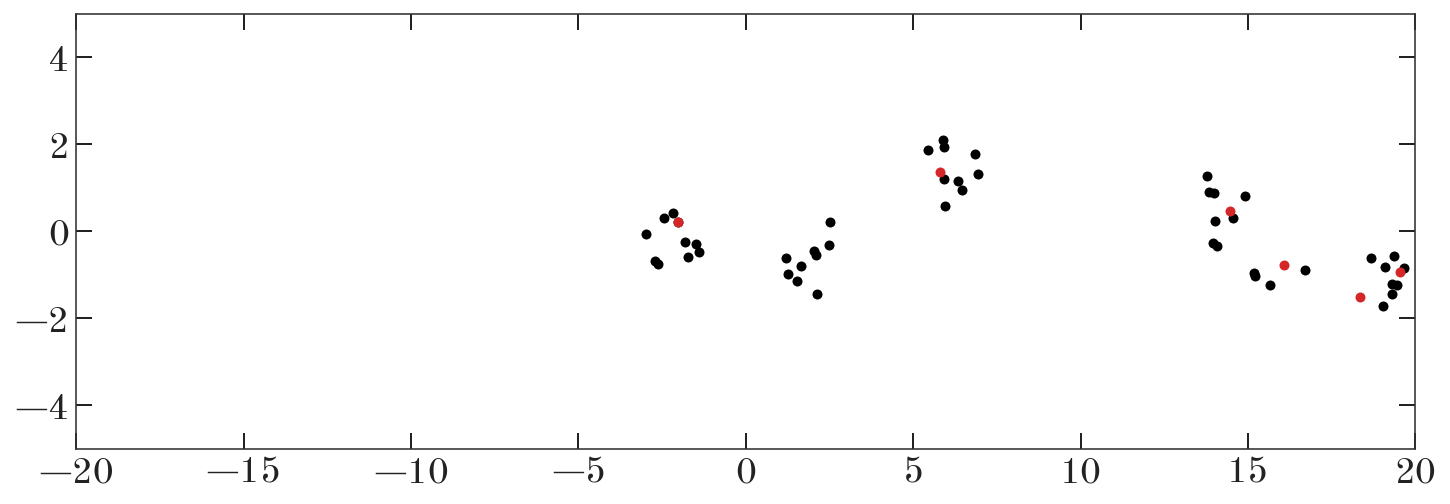

In [140]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

ax.plot(jc.phi1.degree[mask], jc.phi2.degree[mask],
        marker='o', ls='none')

ax.plot(jc.phi1.degree[targets_mask], jc.phi2.degree[targets_mask],
        marker='o', ls='none', color='tab:red')

ax.set_xlim(-20, 20)
ax.set_ylim(-5, 5)

In [141]:
_c = coord.SkyCoord(c.data.without_differentials())
vgsr = gc.vhel_to_vgsr(_c, tbl['VHELIO_AVG']*u.km/u.s, vsun)

In [142]:
from scipy.interpolate import interp1d
vgsr_trend = interp1d([-15, 15], [-12, -160], 
                      bounds_error=False, fill_value='extrapolate')

(-200.0, 50.0)

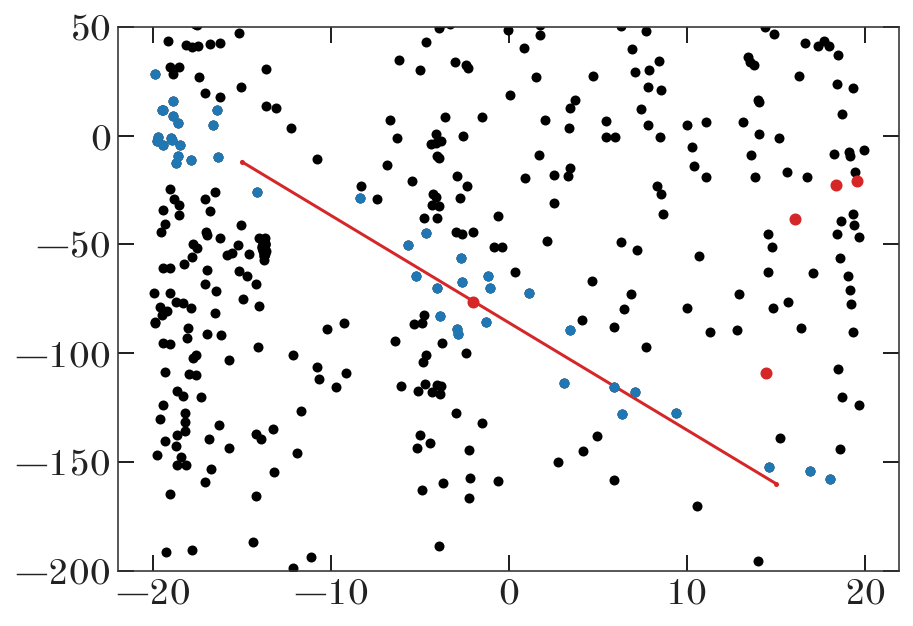

In [143]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

ax.plot(jc.phi1.degree[mask], vgsr.value[mask],
        marker='o', ls='none')

# ax.plot(jc.phi1.degree[jhelum_field_mask], vgsr.value[jhelum_field_mask],
#         marker='o', ls='none')

ax.plot([-15, 15], [-12, -160], color='tab:red')

dv = np.abs(vgsr.value - vgsr_trend(jc.phi1.degree))
trend_mask = dv < 20
ax.plot(jc.phi1.degree[mask & trend_mask], vgsr.value[mask & trend_mask],
        marker='o', ls='none')

ax.scatter(jc.phi1.degree[targets_mask], vgsr.value[targets_mask],
           c='tab:red', zorder=1000)

ax.set_ylim(-200, 50)

In [144]:
targets_vgsr_mask = targets_mask & (vgsr.value < -50)

Text(0, 0.5, '$[\\alpha/M]$')

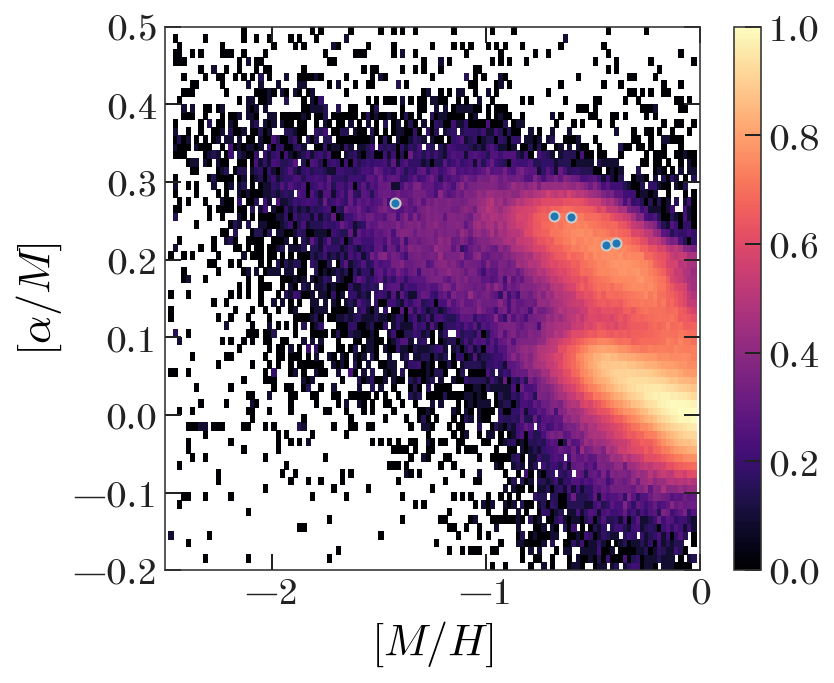

In [145]:
plt.figure(figsize=(6, 5))

plt.scatter(tbl['M_H'][targets_mask], 
            tbl['ALPHA_M'][targets_mask],
            c='tab:blue', linewidth=1, edgecolor='#cccccc',
            zorder=100);
plt.colorbar()

plt.hist2d(tbl['M_H'], tbl['ALPHA_M'],
           bins=(np.arange(-2.5, 0, 0.02),
                 np.arange(-1, 1, 0.01)),
           norm=mpl.colors.LogNorm(),
           zorder=1)

plt.xlim(-2.5, 0)
plt.ylim(-0.2, 0.5)

plt.xlabel('$[M/H]$')
plt.ylabel(r'$[\alpha/M]$')

(-0.2, 0.5)

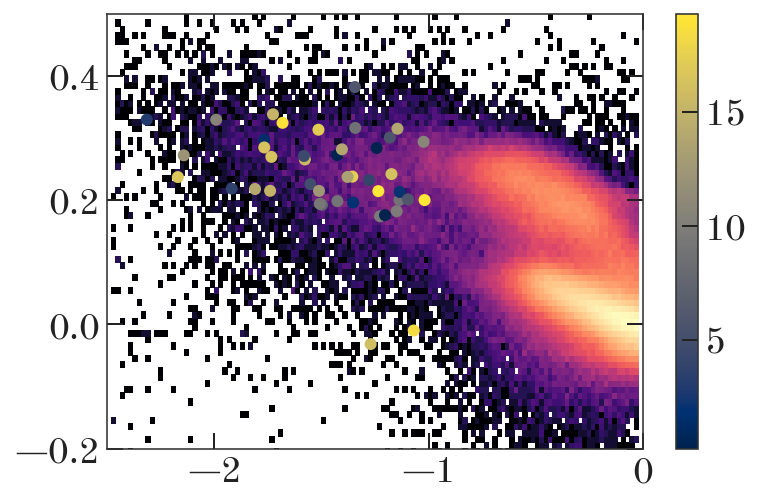

In [146]:
plt.scatter(tbl['M_H'][mask & trend_mask], 
            tbl['ALPHA_M'][mask & trend_mask],
            c=dv[mask & trend_mask], cmap='cividis',
            zorder=100);
plt.colorbar()

plt.hist2d(tbl['M_H'], tbl['ALPHA_M'],
           bins=(np.arange(-2.5, 0, 0.02),
                 np.arange(-1, 1, 0.01)),
           norm=mpl.colors.LogNorm(),
           zorder=1)

plt.xlim(-2.5, 0)
plt.ylim(-0.2, 0.5)

(-0.5, 0.5)

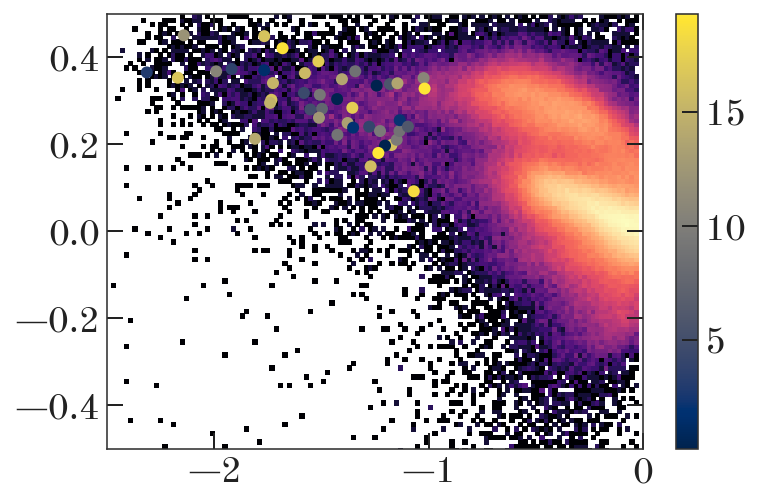

In [147]:
plt.scatter(tbl['M_H'][mask & trend_mask], 
            tbl['MG_FE'][mask & trend_mask],
            c=dv[mask & trend_mask], cmap='cividis',
            zorder=100);
plt.colorbar()

plt.hist2d(tbl['M_H'], tbl['MG_FE'],
           bins=(np.arange(-2.5, 0, 0.02),
                 np.arange(-1, 1, 0.01)),
           norm=mpl.colors.LogNorm(),
           zorder=1)

plt.xlim(-2.5, 0)
plt.ylim(-0.5, 0.5)

---

In [148]:
mw = gp.MilkyWayPotential()

In [149]:
galcen = c.transform_to(galcen_frame)
galcen_targets = galcen[targets_mask]

In [152]:
cyl = galcen.represent_as('cylindrical')

(-15.0, 15.0)

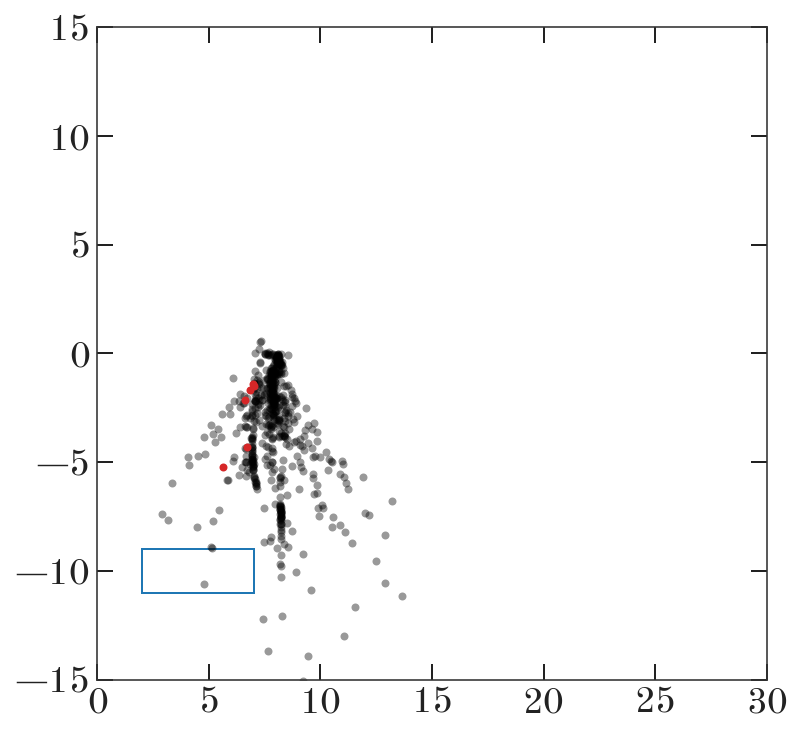

In [167]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

R = cyl.rho.to_value(u.kpc)
z = cyl.z.to_value(u.kpc)

# ax.hist2d(R[mask], z[mask], 
#           bins=(np.arange(0, 25, 0.5),
#                 np.arange(-12.5, 12.5, 0.5)),
#           norm=mpl.colors.LogNorm());

ax.plot(R[mask], z[mask], 
        mew=0, ms=4, marker='o', ls='none', alpha=0.4)

ax.plot(R[targets_mask], z[targets_mask], 
        color='tab:red',
        mew=0, ms=4, marker='o', ls='none', zorder=100)

rect = mpl.patches.Rectangle((2, -11), width=5, height=2, facecolor='none', edgecolor='tab:blue', zorder=-10)
ax.add_patch(rect)

ax.set_xlim(0, 30)
ax.set_ylim(-15, 15)